## Introduction to Data Science

### Create interactive maps, and discover patterns in geospatial data

#### based on Kaggle course - Geospatial Analysis

## Introduction

In this [micro-course](https://www.kaggle.com/alexisbcook/your-first-map), you'll learn about different methods to wrangle and visualize geospatial data, or data with a geographic location.

Along the way, you'll offer solutions to several real-world problems like:

- Where should a global non-profit expand its reach in remote areas of the Philippines?
- How do purple martins, a threatened bird species, travel between North and South America? Are the birds travelling to conservation areas?
- Which areas of Japan could potentially benefit from extra earthquake reinforcement?
- Which Starbucks stores in California are strong candidates for the next Starbucks Reserve Roastery location?
- Does New York City have sufficient hospitals to respond to motor vehicle collisions? Which areas of the city have gaps in coverage?

You'll also visualize crime in the city of Boston, examine health facilities in Ghana, explore top universities in Europe, and track releases of toxic chemicals in the United States.

In this first tutorial, we'll quickly cover the pre-requisites that you'll need to complete this micro-course. And, if you'd like to review more deeply, we recommend the Pandas micro-course.

We'll also get started with visualizing our first geospatial dataset!

In [99]:
#from zipfile import ZipFile

import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import descartes
import rtree #sudo apt install python3-rtree

import geopandas as gpd
from geopandas.tools import geocode

from shapely.geometry import LineString, MultiPolygon

import folium
from folium import Choropleth, Circle, Marker, GeoJson
from folium.plugins import HeatMap, MarkerCluster

from IPython.display import Image, HTML, IFrame, FileLink, FileLinks #needed to render in notebook
from IPython.core.display import display

There are many, many different geospatial file formats, such as shapefile, GeoJSON, KML, and GPKG. We won't discuss their differences in this micro-course, but it's important to mention that:
- shapefile is the most common file type that you'll encounter, and
- all of these file types can be quickly loaded with the gpd.read_file() function.

The next code cell loads a shapefile containing information about forests, wilderness areas, and other lands under the care of the Department of Environmental Conservation in the state of New York.


In [2]:
full_data = gpd.read_file('../datasets/Miscellaneous/geospatial-learn-course-data/DEC_lands/DEC_lands.shp')
# View the first five rows of the data
full_data.head()

,OBJECTID,CATEGORY,UNIT,FACILITY,CLASS,UMP,DESCRIPTIO,REGION,COUNTY,URL,SOURCE,UPDATE_,OFFICE,ACRES,LANDS_UID,GREENCERT,SHAPE_AREA,SHAPE_LEN,geometry
0,1,FOR PRES DET PAR,CFP,HANCOCK FP DETACHED PARCEL,WILD FOREST,None,DELAWARE COUNTY DETACHED PARCEL,4,DELAWARE,http://www.dec.ny.gov/,DELAWARE RPP,5/12,STAMFORD,738.620192,103,N,2.990365e+06,7927.662385,"POLYGON ((486093.245 4635308.586, 486787.235 4..."
1,2,FOR PRES DET PAR,CFP,HANCOCK FP DETACHED PARCEL,WILD FOREST,None,DELAWARE COUNTY DETACHED PARCEL,4,DELAWARE,http://www.dec.ny.gov/,DELAWARE RPP,5/12,STAMFORD,282.553140,1218,N,1.143940e+06,4776.375600,"POLYGON ((491931.514 4637416.256, 491305.424 4..."
2,3,FOR PRES DET PAR,CFP,HANCOCK FP DETACHED PARCEL,WILD FOREST,None,DELAWARE COUNTY DETACHED PARCEL,4,DELAWARE,http://www.dec.ny.gov/,DELAWARE RPP,5/12,STAMFORD,234.291262,1780,N,9.485476e+05,5783.070364,"POLYGON ((486000.287 4635834.453, 485007.550 4..."
3,4,FOR PRES DET PAR,CFP,GREENE COUNTY FP DETACHED PARCEL,WILD FOREST,None,None,4,GREENE,http://www.dec.ny.gov/,GREENE RPP,5/12,STAMFORD,450.106464,2060,N,1.822293e+06,7021.644833,"POLYGON ((541716.775 4675243.268, 541217.579 4..."
4,6,FOREST PRESERVE,AFP,SARANAC LAKES WILD FOREST,WILD FOREST,SARANAC LAKES,None,5,ESSEX,http://www.dec.ny.gov/lands/22593.html,"DECRP, ESSEX RPP",12/96,RAY BROOK,69.702387,1517,N,2.821959e+05,2663.909932,"POLYGON ((583896.043 4909643.187, 583891.200 4..."


As you can see in the "CLASS" column, each of the first five rows corresponds to a different forest.

For the rest of this tutorial, consider a scenario where you'd like to use this data to plan a weekend camping trip. Instead of relying on crowd-sourced reviews online, you decide to create your own map. This way, you can tailor the trip to your specific interests.
Prerequisites

To view the first five rows of the data, we used the head() method. You may recall that this is also what we use to preview a Pandas DataFrame. In fact, every command that you can use with a DataFrame will work with the data!

This is because the data was loaded into a (GeoPandas) GeoDataFrame object that has all of the capabilities of a (Pandas) DataFrame.

In [3]:
type(full_data)

geopandas.geodataframe.GeoDataFrame



For instance, if we don't plan to use all of the columns, we can select a subset of them. (To review other methods for selecting data, check out this tutorial from the Pandas micro-course.)


In [4]:
data = full_data.loc[:, ["CLASS", "COUNTY", "geometry"]].copy()

In [5]:
data.CLASS.value_counts()

WILD FOREST                   965
INTENSIVE USE                 108
PRIMITIVE                      60
WILDERNESS                     52
ADMINISTRATIVE                 17
UNCLASSIFIED                    7
HISTORIC                        5
PRIMITIVE BICYCLE CORRIDOR      4
CANOE AREA                      1
Name: CLASS, dtype: int64

In [6]:
# Select lands that fall under the "WILD FOREST" or "WILDERNESS" category
wild_lands = data.loc[data.CLASS.isin(['WILD FOREST', 'WILDERNESS'])].copy()
wild_lands.head()

,CLASS,COUNTY,geometry
0,WILD FOREST,DELAWARE,"POLYGON ((486093.245 4635308.586, 486787.235 4..."
1,WILD FOREST,DELAWARE,"POLYGON ((491931.514 4637416.256, 491305.424 4..."
2,WILD FOREST,DELAWARE,"POLYGON ((486000.287 4635834.453, 485007.550 4..."
3,WILD FOREST,GREENE,"POLYGON ((541716.775 4675243.268, 541217.579 4..."
4,WILD FOREST,ESSEX,"POLYGON ((583896.043 4909643.187, 583891.200 4..."


## I - Create your first map!

We can quickly visualize the data with the plot() method.

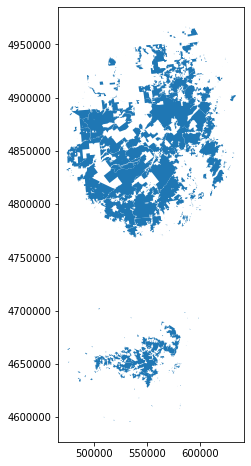

In [7]:
wild_lands.plot(figsize=(8,8))

Every GeoDataFrame contains a special "geometry" column. It contains all of the geometric objects that are displayed when we call the plot() method.


While this column can contain a variety of different datatypes, each entry will typically be a Point, LineString, or Polygon.

The "geometry" column in our dataset contains 2983 different Polygon objects, each corresponding to a different shape in the plot above.

In the code cell below, we create three more GeoDataFrames, containing campsite locations (Point), foot trails (LineString), and county boundaries (Polygon).

In [8]:
# View the first five entries in the "geometry" column
wild_lands.geometry.head()

0    POLYGON ((486093.245 4635308.586, 486787.235 4...
1    POLYGON ((491931.514 4637416.256, 491305.424 4...
2    POLYGON ((486000.287 4635834.453, 485007.550 4...
3    POLYGON ((541716.775 4675243.268, 541217.579 4...
4    POLYGON ((583896.043 4909643.187, 583891.200 4...
Name: geometry, dtype: geometry

In [9]:
# Campsites in New York state (Point)
POI_data = gpd.read_file("../datasets/Miscellaneous/geospatial-learn-course-data/DEC_pointsinterest/Decptsofinterest.shp")
campsites = POI_data.loc[POI_data.ASSET=='PRIMITIVE CAMPSITE'].copy()

# Foot trails in New York state (LineString)
roads_trails = gpd.read_file("../datasets/Miscellaneous/geospatial-learn-course-data/DEC_roadstrails/Decroadstrails.shp")
trails = roads_trails.loc[roads_trails.ASSET=='FOOT TRAIL'].copy()

# County boundaries in New York state (Polygon)
counties = gpd.read_file("../datasets/Miscellaneous/geospatial-learn-course-data/NY_county_boundaries/NY_county_boundaries.shp")




Next, we create a map from all four GeoDataFrames.

The plot() method takes as (optional) input several parameters that can be used to customize the appearance. Most importantly, setting a value for ax ensures that all of the information is plotted on the same map.


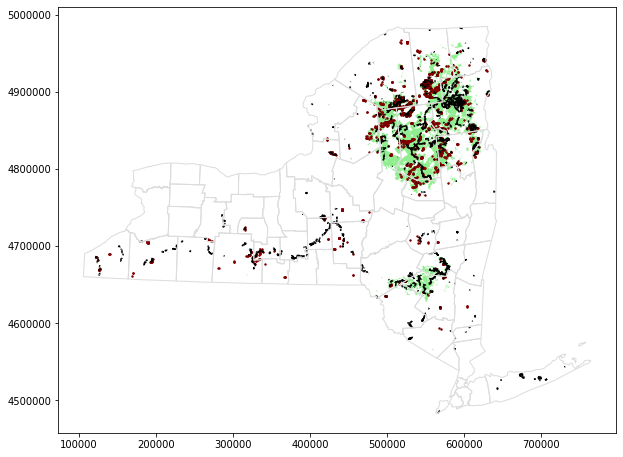

In [10]:
# Define a base map with county boundaries
ax = counties.plot(figsize=(10,10), color='none', edgecolor='gainsboro', zorder=3)

# Add wild lands, campsites, and foot trails to the base map
wild_lands.plot(color='lightgreen', ax=ax)
campsites.plot(color='maroon', markersize=2, ax=ax)
trails.plot(color='black', markersize=1, ax=ax)

### Exercise for part I

[Kiva.org](https://www.kiva.org/) is an online crowdfunding platform extending financial services to poor people around the world. Kiva lenders have provided over $1 billion dollars in loans to over 2 million people.

<center>
<img src="https://i.imgur.com/2G8C53X.png" width="500"><br/>
</center>

Kiva reaches some of the most remote places in the world through their global network of "Field Partners". These partners are local organizations working in communities to vet borrowers, provide services, and administer loans.

In this exercise, you'll investigate Kiva loans in the Philippines.  Can you identify regions that might be outside of Kiva's current network, in order to identify opportunities for recruiting new Field Partners?

In [11]:
loans_filepath = "../datasets/Miscellaneous/geospatial-learn-course-data/kiva_loans/kiva_loans.shp"
world_loans = gpd.read_file(loans_filepath)
world_loans.head()

,Partner ID,Field Part,sector,Loan Theme,country,amount,geometry
0,9,KREDIT Microfinance Institution,General Financial Inclusion,Higher Education,Cambodia,450,POINT (102.89751 13.66726)
1,9,KREDIT Microfinance Institution,General Financial Inclusion,Vulnerable Populations,Cambodia,20275,POINT (102.98962 13.02870)
2,9,KREDIT Microfinance Institution,General Financial Inclusion,Higher Education,Cambodia,9150,POINT (102.98962 13.02870)
3,9,KREDIT Microfinance Institution,General Financial Inclusion,Vulnerable Populations,Cambodia,604950,POINT (105.31312 12.09829)
4,9,KREDIT Microfinance Institution,General Financial Inclusion,Sanitation,Cambodia,275,POINT (105.31312 12.09829)


In [12]:
world_loans.country.value_counts()

Philippines    3083
Armenia         942
Colombia        822
Mexico          615
Kenya           568
               ... 
Canada            1
Benin             1
South Sudan       1
Suriname          1
Afghanistan       1
Name: country, Length: 79, dtype: int64

In [13]:
# This dataset is provided in GeoPandas
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


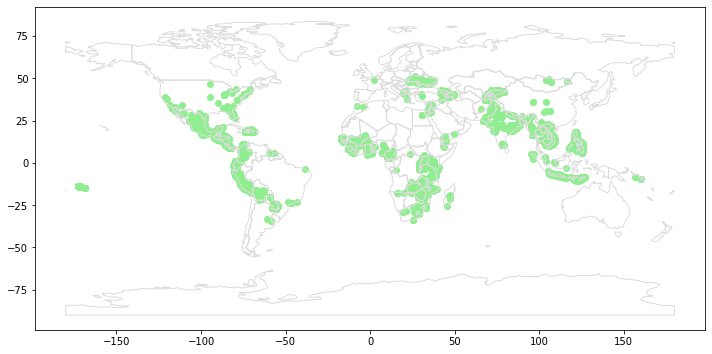

In [14]:
ax = world.plot(figsize=(12,12), color='none', edgecolor='gainsboro', zorder=3)
world_loans.plot(color='lightgreen', ax=ax)

In [15]:
PHL_loans = world_loans[world_loans['country'] == 'Philippines']
PHL_loans.head()

,Partner ID,Field Part,sector,Loan Theme,country,amount,geometry
2859,123,Alalay sa Kaunlaran (ASKI),General Financial Inclusion,General,Philippines,400,POINT (121.73961 17.64228)
2860,123,Alalay sa Kaunlaran (ASKI),General Financial Inclusion,General,Philippines,400,POINT (121.74169 17.63235)
2861,123,Alalay sa Kaunlaran (ASKI),General Financial Inclusion,General,Philippines,400,POINT (121.46667 16.60000)
2862,123,Alalay sa Kaunlaran (ASKI),General Financial Inclusion,General,Philippines,6050,POINT (121.73333 17.83333)
2863,123,Alalay sa Kaunlaran (ASKI),General Financial Inclusion,General,Philippines,625,POINT (121.51800 16.72368)


In [16]:
# Load a KML file containing island boundaries
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
PHL = gpd.read_file("../datasets/Miscellaneous/geospatial-learn-course-data/Philippines_AL258.kml", driver='KML')
PHL.head()

,Name,Description,geometry
0,Autonomous Region in Muslim Mindanao,,"MULTIPOLYGON (((119.46690 4.58718, 119.46653 4..."
1,Bicol Region,,"MULTIPOLYGON (((124.04577 11.57862, 124.04594 ..."
2,Cagayan Valley,,"MULTIPOLYGON (((122.51581 17.04436, 122.51568 ..."
3,Calabarzon,,"MULTIPOLYGON (((120.49202 14.05403, 120.49201 ..."
4,Caraga,,"MULTIPOLYGON (((126.45401 8.24400, 126.45407 8..."


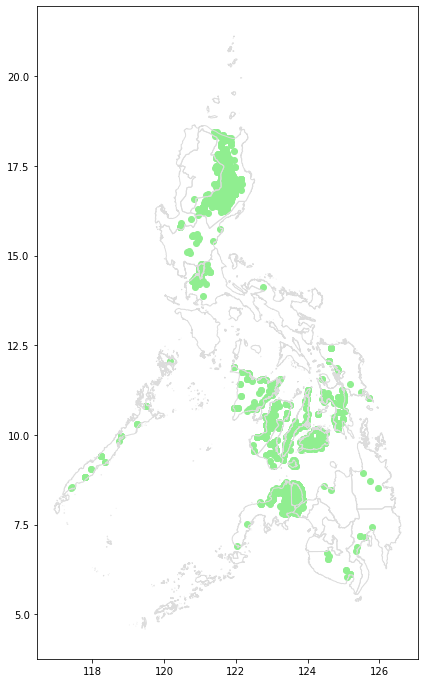

In [17]:
ax = PHL.plot(figsize=(12,12), color='none', edgecolor='gainsboro', zorder=3)
PHL_loans.plot(color='lightgreen', ax=ax)

## II - Coordinate reference system (CRS)

The maps you create in this course portray the surface of the earth in two dimensions. But, as you know, the world is actually a three-dimensional globe. So we have to use a method called a map projection to render it as a flat surface.

Map projections can't be 100% accurate. Each projection distorts the surface of the Earth in some way, while retaining some useful property. For instance,

- the equal-area projections (like "Lambert Cylindrical Equal Area", or "Africa Albers Equal Area Conic") preserve area. This is a good choice, if you'd like to calculate the area of a country or city, for example.
- the equidistant projections (like "Azimuthal Equidistant projection") preserve distance. This would be a good choice for calculating flight distance.

[List of map projections](https://bit.ly/2kOHTBs)

We use a coordinate reference system (CRS) to show how the projected points correspond to real locations on Earth. In this tutorial, you'll learn more about coordinate reference systems, along with how to use them in GeoPandas.

#### Setting the CRS

When we create a GeoDataFrame from a shapefile, the CRS is already imported for us.

In [18]:
# Load a GeoDataFrame containing regions in Ghana
regions = gpd.read_file("../datasets/Miscellaneous/geospatial-learn-course-data/ghana/Regions/Map_of_Regions_in_Ghana.shp")
print(regions.crs)

{'init': 'epsg:32630'}


How do you interpret that?

Coordinate reference systems are referenced by European Petroleum Survey Group (EPSG) codes.

This GeoDataFrame uses EPSG 32630, which is more commonly called the "Mercator" projection. This projection preserves angles (making it useful for sea navigation) and slightly distorts area.

However, when creating a GeoDataFrame from a CSV file, we have to set the CRS. EPSG 4326 corresponds to coordinates in latitude and longitude.


In [19]:
# Create a DataFrame with health facilities in Ghana
facilities_df = pd.read_csv("../datasets/Miscellaneous/geospatial-learn-course-data/ghana/health_facilities.csv")

# Convert the DataFrame to a GeoDataFrame
facilities = gpd.GeoDataFrame(facilities_df, 
                              geometry=gpd.points_from_xy(facilities_df.Longitude, facilities_df.Latitude))

# Set the coordinate reference system (CRS) to EPSG 4326
facilities.crs = {'init': 'epsg:4326'}

# View the first five rows of the GeoDataFrame
facilities.head()

,Region,District,FacilityName,Type,Town,Ownership,Latitude,Longitude,geometry
0,Ashanti,Offinso North,A.M.E Zion Clinic,Clinic,Afrancho,CHAG,7.40801,-1.96317,POINT (-1.96317 7.40801)
1,Ashanti,Bekwai Municipal,Abenkyiman Clinic,Clinic,Anwiankwanta,Private,6.46312,-1.58592,POINT (-1.58592 6.46312)
2,Ashanti,Adansi North,Aboabo Health Centre,Health Centre,Aboabo No 2,Government,6.22393,-1.34982,POINT (-1.34982 6.22393)
3,Ashanti,Afigya-Kwabre,Aboabogya Health Centre,Health Centre,Aboabogya,Government,6.84177,-1.61098,POINT (-1.61098 6.84177)
4,Ashanti,Kwabre,Aboaso Health Centre,Health Centre,Aboaso,Government,6.84177,-1.61098,POINT (-1.61098 6.84177)


In the code cell above, to create a GeoDataFrame from a CSV file, we needed to use both Pandas and GeoPandas:

- We begin by creating a DataFrame containing columns with latitude and longitude coordinates.
- To convert it to a GeoDataFrame, we use gpd.GeoDataFrame().
- The gpd.points_from_xy() function creates Point objects from the latitude and longitude columns.

#### Re-projecting

Re-projecting refers to the process of changing the CRS. This is done in GeoPandas with the to_crs() method.

When plotting multiple GeoDataFrames, it's important that they all use the same CRS. In the code cell below, we change the CRS of the facilities GeoDataFrame to match the CRS of regions before plotting it.

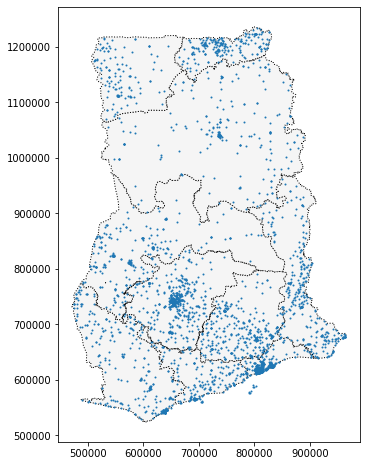

In [20]:
# Create a map
ax = regions.plot(figsize=(8,8), color='whitesmoke', linestyle=':', edgecolor='black')
facilities.to_crs(epsg=32630).plot(markersize=1, ax=ax)

The to_crs() method modifies only the "geometry" column: all other columns are left as-is.

In [21]:
# The "Latitude" and "Longitude" columns are unchanged
facilities.to_crs(epsg=32630).head()

,Region,District,FacilityName,Type,Town,Ownership,Latitude,Longitude,geometry
0,Ashanti,Offinso North,A.M.E Zion Clinic,Clinic,Afrancho,CHAG,7.40801,-1.96317,POINT (614422.662 818986.851)
1,Ashanti,Bekwai Municipal,Abenkyiman Clinic,Clinic,Anwiankwanta,Private,6.46312,-1.58592,POINT (656373.863 714616.547)
2,Ashanti,Adansi North,Aboabo Health Centre,Health Centre,Aboabo No 2,Government,6.22393,-1.34982,POINT (682573.395 688243.477)
3,Ashanti,Afigya-Kwabre,Aboabogya Health Centre,Health Centre,Aboabogya,Government,6.84177,-1.61098,POINT (653484.490 756478.812)
4,Ashanti,Kwabre,Aboaso Health Centre,Health Centre,Aboaso,Government,6.84177,-1.61098,POINT (653484.490 756478.812)


In case the EPSG code is not available in GeoPandas, we can change the CRS with what's known as the "proj4 string" of the CRS. For instance, the proj4 string to convert to latitude/longitude coordinates is as follows:

+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs

In [22]:
# Change the CRS to EPSG 4326
regions.to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs").head()

,Region,geometry
0,Ashanti,"POLYGON ((-1.30985 7.62302, -1.30786 7.62198, ..."
1,Brong Ahafo,"POLYGON ((-2.54567 8.76089, -2.54473 8.76071, ..."
2,Central,"POLYGON ((-2.06723 6.29473, -2.06658 6.29420, ..."
3,Eastern,"POLYGON ((-0.21751 7.21009, -0.21747 7.20993, ..."
4,Greater Accra,"POLYGON ((0.23456 6.10986, 0.23484 6.10974, 0...."


Attributes of geometric objects

As you learned in the first tutorial, for an arbitrary GeoDataFrame, the type in the "geometry" column depends on what we are trying to show: for instance, we might use:

- a Point for the epicenter of an earthquake,
- a LineString for a street, or
- a Polygon to show country boundaries.

All three types of geometric objects have built-in attributes that you can use to quickly analyze the dataset. For instance, you can get the x- and y-coordinates of a Point from the x and y attributes, respectively.

In [23]:
# Get the x-coordinate of each point
facilities.geometry.x.head()

0   -1.96317
1   -1.58592
2   -1.34982
3   -1.61098
4   -1.61098
dtype: float64


And, you can get the length of a LineString from the length attribute.  
Or, you can get the area of a Polygon from the area attribute.

In [24]:
# Calculate the area (in square meters) of each polygon in the GeoDataFrame 
regions.loc[:, "AREA"] = regions.geometry.area / 10**6

print("Area of Ghana: {} square kilometers".format(regions.AREA.sum()))
print("CRS:", regions.crs)
regions.head()

Area of Ghana: 239584.5760055668 square kilometers
CRS: {'init': 'epsg:32630'}


,Region,geometry,AREA
0,Ashanti,"POLYGON ((686446.075 842986.894, 686666.193 84...",24379.017777
1,Brong Ahafo,"POLYGON ((549970.457 968447.094, 550073.003 96...",40098.168231
2,Central,"POLYGON ((603176.584 695877.238, 603248.424 69...",9665.626760
3,Eastern,"POLYGON ((807307.254 797910.553, 807311.908 79...",18987.625847
4,Greater Accra,"POLYGON ((858081.638 676424.913, 858113.115 67...",3706.511145


In the code cell above, since the CRS of the regions GeoDataFrame is set to EPSG 32630 (a "Mercator" projection), the area calculation is slightly less accurate than if we had used an equal-area projection like "Africa Albers Equal Area Conic".

But this yields the area of Ghana as approximately 239585 square kilometers, which is not too far off from the correct answer.

### Exercise for part II


You are a bird conservation expert and want to understand migration patterns of purple martins.  In your research, you discover that these birds typically spend the summer breeding season in the eastern United States, and then migrate to South America for the winter.  But since this bird is under threat of endangerment, you'd like to take a closer look at the locations that these birds are more likely to visit.

<center>
<img src="https://i.imgur.com/qQcS0KM.png" width="1000"><br/>
</center>

There are several [protected areas](https://www.iucn.org/theme/protected-areas/about) in South America, which operate under special regulations to ensure that species that migrate (or live) there have the best opportunity to thrive.  You'd like to know if purple martins tend to visit these areas.  To answer this question, you'll use some recently collected data that tracks the year-round location of eleven different birds.

In [25]:
# Load the data and print the first 5 rows
birds_df = pd.read_csv("../datasets/Miscellaneous/geospatial-learn-course-data/purple_martin.csv", 
                       parse_dates=['timestamp'])
print("There are {} different birds in the dataset.".format(birds_df["tag-local-identifier"].nunique()))
birds_df.head()

There are 11 different birds in the dataset.


,timestamp,location-long,location-lat,tag-local-identifier
0,2014-08-15 05:56:00,-88.146014,17.513049,30448
1,2014-09-01 05:59:00,-85.243501,13.095782,30448
2,2014-10-30 23:58:00,-62.906089,-7.852436,30448
3,2014-11-15 04:59:00,-61.776826,-11.723898,30448
4,2014-11-30 09:59:00,-61.241538,-11.612237,30448


In [26]:
# Convert the DataFrame to a GeoDataFrame
birds = gpd.GeoDataFrame(birds_df, geometry=gpd.points_from_xy(birds_df['location-long'], 
                                                               birds_df['location-lat']))

# Set the coordinate reference system (CRS) to EPSG 4326
birds.crs = {'init': 'epsg:4326'}

# View the first five rows of the GeoDataFrame
birds.head()

,timestamp,location-long,location-lat,tag-local-identifier,geometry
0,2014-08-15 05:56:00,-88.146014,17.513049,30448,POINT (-88.14601 17.51305)
1,2014-09-01 05:59:00,-85.243501,13.095782,30448,POINT (-85.24350 13.09578)
2,2014-10-30 23:58:00,-62.906089,-7.852436,30448,POINT (-62.90609 -7.85244)
3,2014-11-15 04:59:00,-61.776826,-11.723898,30448,POINT (-61.77683 -11.72390)
4,2014-11-30 09:59:00,-61.241538,-11.612237,30448,POINT (-61.24154 -11.61224)


Next, we load in the `'naturalearth_lowres'` dataset from GeoPandas, and set `americas` to a GeoDataFrame containing the boundaries of all countries in the Americas (both North and South America).

In [27]:
# Load a GeoDataFrame with country boundaries in North/South America, print the first 5 rows
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
americas = world.loc[world['continent'].isin(['North America', 'South America'])]
americas.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
9,44293293,South America,Argentina,ARG,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000..."
10,17789267,South America,Chile,CHL,436100.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335..."
16,10646714,North America,Haiti,HTI,19340.0,"POLYGON ((-71.71236 19.71446, -71.62487 19.169..."


We will create a single plot that shows both: 
- the country boundaries in the `americas` GeoDataFrame, and 
- all of the points in the `birds_gdf` GeoDataFrame.  

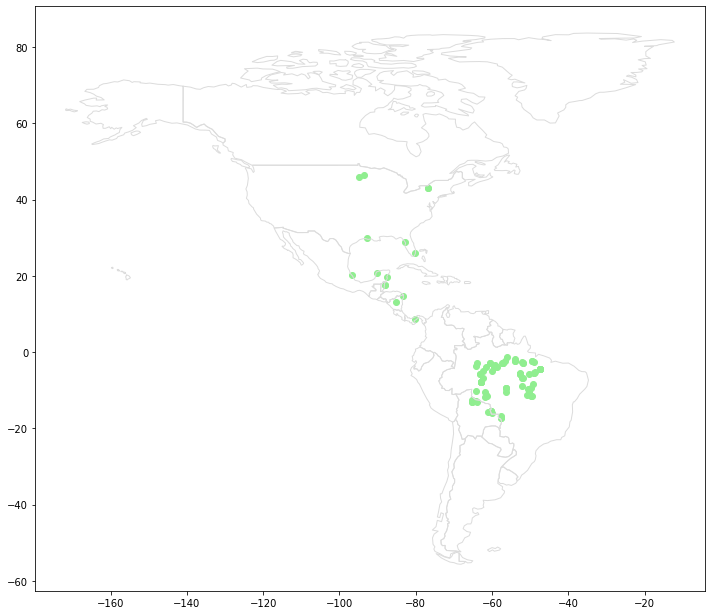

In [28]:
ax = americas.plot(figsize=(12,12), color='none', edgecolor='gainsboro', zorder=3)
birds.plot(color='lightgreen', ax=ax)

#### Where does each bird start and end its journey? (Part 1)

Now, we're ready to look more closely at each bird's path.  The next code cell create two GeoDataFrames:
- `path_gdf` contains LineString objects that show the path of each bird.  It uses the `LineString()` method to create a LineString object from a list of Point objects.
- `start_gdf` contains the starting points for each bird.

In [29]:
# GeoDataFrame showing path for each bird
path_df = birds.groupby("tag-local-identifier")['geometry'].apply(list).apply(lambda x: LineString(x)).reset_index()
path_gdf = gpd.GeoDataFrame(path_df, geometry=path_df.geometry)
path_gdf.crs = {'init' :'epsg:4326'}

# GeoDataFrame showing starting point for each bird
start_df = birds.groupby("tag-local-identifier")['geometry'].apply(list).apply(lambda x: x[0]).reset_index()
start_gdf = gpd.GeoDataFrame(start_df, geometry=start_df.geometry)
start_gdf.crs = {'init' :'epsg:4326'}

# Show first five rows of GeoDataFrame
start_gdf.head()

,tag-local-identifier,geometry
0,30048,POINT (-90.12992 20.73242)
1,30054,POINT (-93.60861 46.50563)
2,30198,POINT (-80.31036 25.92545)
3,30263,POINT (-76.78146 42.99209)
4,30275,POINT (-76.78213 42.99207)


Now we create a GeoDataFrame `end_gdf` containing the final location of each bird.  
- The format is identical to that of `start_gdf`, with two columns ("tag-local-identifier" and "geometry"), where the "geometry" column contains Point objects.
- The CRS of `end_gdf` is `{'init': 'epsg:4326'}`.

In [30]:
# GeoDataFrame showing final point for each bird
end_df = birds.groupby("tag-local-identifier")['geometry'].apply(list).apply(lambda x: x[-1]).reset_index()
end_gdf = gpd.GeoDataFrame(end_df, geometry=end_df.geometry)
end_gdf.crs = {'init' :'epsg:4326'}

# Show first five rows of GeoDataFrame
end_gdf.head()

,tag-local-identifier,geometry
0,30048,POINT (-47.53632 -4.43758)
1,30054,POINT (-62.47914 -5.03840)
2,30198,POINT (-57.46417 -2.77617)
3,30263,POINT (-50.19230 -5.70504)
4,30275,POINT (-57.70404 -16.72336)


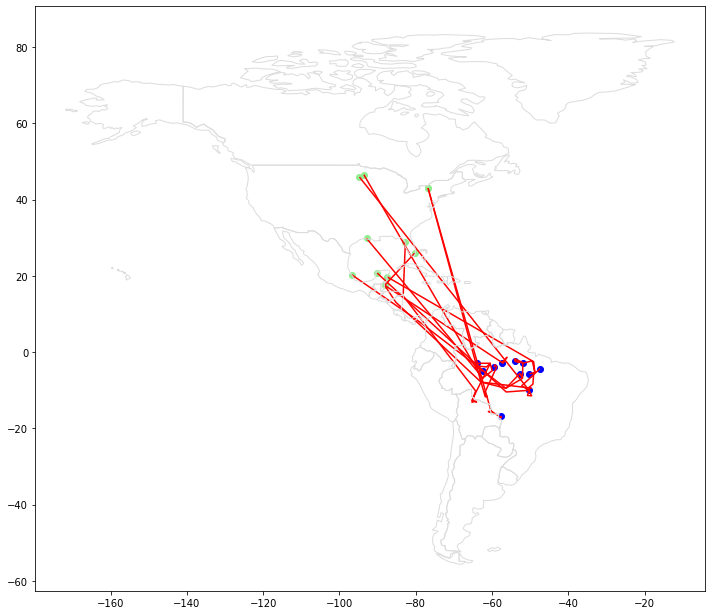

In [31]:
ax = americas.plot(figsize=(12,12), color='none', edgecolor='gainsboro', zorder=3)
start_gdf.plot(color='lightgreen', ax=ax)
path_gdf.plot(color='red', ax=ax)
end_gdf.plot(color='blue', ax=ax)

#### Where are the protected areas in South America?

It looks like all of the birds end up somewhere in South America.  But are they going to protected areas?

In the next code cell, you'll create a GeoDataFrame `protected_areas` containing the locations of all of the protected areas in South America.  The corresponding shapefile is located at filepath `protected_filepath`.

In [32]:
# Path of the shapefile to load
protected_filepath = "../datasets/Miscellaneous/geospatial-learn-course-data/SAPA_Aug2019-shapefile/SAPA_Aug2019-shapefile-polygons.shp"

# Your code here
protected_areas = gpd.read_file(protected_filepath)
protected_areas.head()

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NAME,DESIG,DESIG_ENG,DESIG_TYPE,IUCN_CAT,INT_CRIT,...,GOV_TYPE,OWN_TYPE,MANG_AUTH,MANG_PLAN,VERIF,METADATAID,SUB_LOC,PARENT_ISO,ISO3,geometry
0,14067.0,14067,1,Het Spaans Lagoen,Het Spaans Lagoen,"Ramsar Site, Wetland of International Importance","Ramsar Site, Wetland of International Importance",International,Not Reported,Not Reported,...,Not Reported,Not Reported,Not Reported,Management plan is not implemented and not ava...,State Verified,1856,Not Reported,NLD,ABW,"POLYGON ((-69.97523 12.47379, -69.97523 12.473..."
1,14003.0,14003,1,Bubali Pond Bird Sanctuary,Bubali Pond Bird Sanctuary,Bird Sanctuary,Bird Sanctuary,National,Not Reported,Not Applicable,...,Not Reported,Not Reported,Not Reported,Not Reported,State Verified,1899,Not Reported,NLD,ABW,"POLYGON ((-70.04734 12.56329, -70.04615 12.563..."
2,555624439.0,555624439,1,Arikok National Park,Arikok National Park,National Park,National Park,National,Not Reported,Not Applicable,...,Non-profit organisations,Non-profit organisations,Fundacion Parke Nacional Arikok,Not Reported,State Verified,1899,Not Reported,NLD,ABW,"MULTIPOLYGON (((-69.96302 12.48384, -69.96295 ..."
3,303894.0,303894,1,Madidi,Madidi,Area Natural de Manejo Integrado,Natural Integrated Management Area,National,Not Reported,Not Applicable,...,Federal or national ministry or agency,Not Reported,Not Reported,Not Reported,State Verified,1860,BO-L,BOL,BOL,"POLYGON ((-68.59060 -14.43388, -68.59062 -14.4..."
4,303893.0,303893,1,Apolobamba,Apolobamba,Area Natural de Manejo Integado Nacional,National Natural Integrated Management Area,National,Not Reported,Not Applicable,...,Federal or national ministry or agency,Not Reported,Not Reported,Not Reported,State Verified,1860,BO-L,BOL,BOL,"POLYGON ((-69.20949 -14.73334, -69.20130 -14.7..."


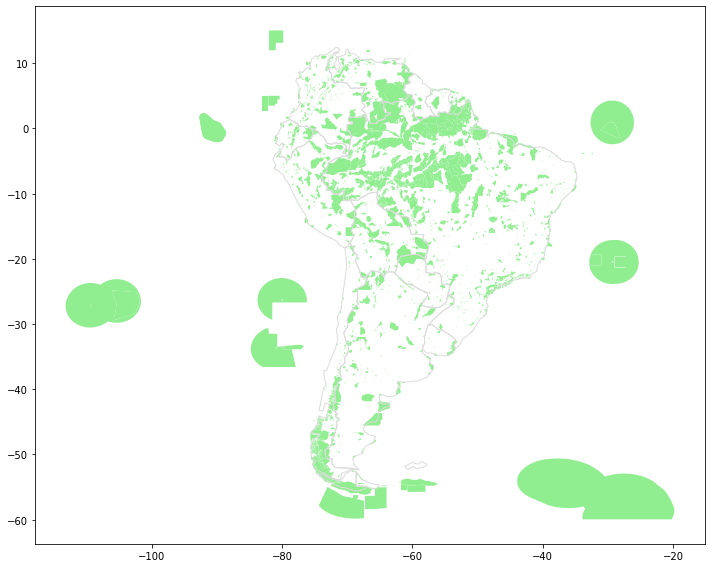

In [33]:
# Country boundaries in South America
south_america = americas.loc[americas['continent']=='South America']
ax = south_america.plot(figsize=(12,12), color='none', edgecolor='gainsboro', zorder=3)
protected_areas.plot(color='lightgreen', ax=ax)

You're interested in determining what percentage of South America is protected, so that you know how much of South America is suitable for the birds.  

As a first step, you calculate the total area of all protected lands in South America (not including marine area).  To do this, you use the "REP_AREA" and "REP_M_AREA" columns, which contain the total area and total marine area, respectively, in square kilometers.

In [34]:
P_Area = sum(protected_areas['REP_AREA']-protected_areas['REP_M_AREA'])
print("South America has {} square kilometers of protected areas.".format(P_Area))

South America has 5396761.9116883585 square kilometers of protected areas.


In [35]:
south_america.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
9,44293293,South America,Argentina,ARG,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000..."
10,17789267,South America,Chile,CHL,436100.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335..."
20,2931,South America,Falkland Is.,FLK,281.8,"POLYGON ((-61.20000 -51.85000, -60.00000 -51.2..."
28,3360148,South America,Uruguay,URY,73250.0,"POLYGON ((-57.62513 -30.21629, -56.97603 -30.1..."
29,207353391,South America,Brazil,BRA,3081000.0,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2..."


Let's calculate the total area of South America by following these steps:
- Calculate the area of each country using the `area` attribute of each polygon (with EPSG 3035 as the CRS), and add up the results.  The calculated area will be in units of square meters.
- Convert your answer to have units of square kilometeters.

In [36]:
totalArea = sum(south_america.geometry.to_crs(epsg=3035).area) / 10**6

# What percentage of South America is protected?
percentage_protected = P_Area/totalArea
print('Approximately {}% of South America is protected.'.format(round(percentage_protected*100, 2)))

Approximately 30.39% of South America is protected.


#### Where are the birds in South America?

So, are the birds in protected areas?  

Create a plot that shows for all birds, all of the locations where they were discovered in South America.  Also plot the locations of all protected areas in South America.

To exclude protected areas that are purely marine areas (with no land component), you can use the "MARINE" column (and plot only the rows in `protected_areas[protected_areas['MARINE']!='2']`, instead of every row in the `protected_areas` GeoDataFrame).

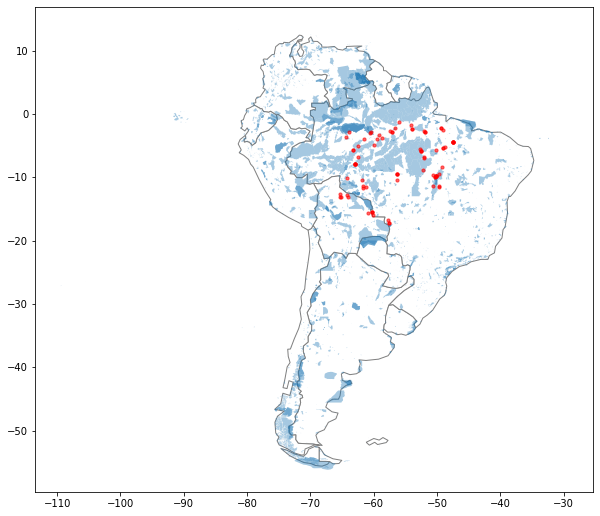

In [37]:
ax = south_america.plot(figsize=(10,10), color='white', edgecolor='gray')
protected_areas[protected_areas['MARINE']!='2'].plot(ax=ax, alpha=0.4, zorder=1)
birds[birds.geometry.y < 0].plot(ax=ax, color='red', alpha=0.6, markersize=10, zorder=2)

## III Interactive Maps 

In this part, we will create interactive maps with the folium package. Along the way, we'll apply these skills to visualize Boston crime data.

We define a function embed_map() for displaying interactive maps. It accepts two arguments: the variable containing the map, and the name of the HTML file where the map will be saved.

This function ensures that the maps are visible in all web browsers.

In [39]:
# Function for displaying the map
def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='500px')


Your first interactive map

We begin by creating a relatively simple map with folium.Map().


In [40]:
# Create a map
m_1 = folium.Map(location=[42.32,-71.0589], tiles='openstreetmap', zoom_start=10)

# Display the map
embed_map(m_1, '../outputs/m_1.html')



Several arguments customize the appearance of the map:

- location sets the initial center of the map. We use the latitude (42.32° N) and longitude (-71.0589° E) of the city of Boston.
- tiles changes the styling of the map; in this case, we choose the OpenStreetMap style. If you're curious, you can find the other options listed here.
- zoom_start sets the initial level of zoom of the map, where higher values zoom in closer to the map.

Take the time now to explore by zooming in and out, or by dragging the map in different directions.

The data

Now, we'll add some crime data to the map!

We won't focus on the data loading step. Instead, you can imagine you are at a point where you already have the data in a pandas DataFrame crimes. The first five rows of the data are shown below.

In [41]:
# Load the data
crimes = pd.read_csv("../datasets/Miscellaneous/geospatial-learn-course-data/crimes-in-boston/crime.csv", encoding='latin-1')

# Drop rows with missing locations
crimes.dropna(subset=['Lat', 'Long', 'DISTRICT'], inplace=True)

# Focus on major crimes in 2018
crimes = crimes[crimes.OFFENSE_CODE_GROUP.isin([
    'Larceny', 'Auto Theft', 'Robbery', 'Larceny From Motor Vehicle', 'Residential Burglary',
    'Simple Assault', 'Harassment', 'Ballistics', 'Aggravated Assault', 'Other Burglary', 
    'Arson', 'Commercial Burglary', 'HOME INVASION', 'Homicide', 'Criminal Harassment', 
    'Manslaughter'])]
crimes = crimes[crimes.YEAR>=2018]

# Print the first five rows of the table
crimes.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
6,I182070933,724,Auto Theft,AUTO THEFT,B2,330,NaN,2018-09-03 21:25:00,2018,9,Monday,21,Part One,NORMANDY ST,42.306072,-71.082733,"(42.30607218, -71.08273260)"
8,I182070931,301,Robbery,ROBBERY - STREET,C6,177,NaN,2018-09-03 20:48:00,2018,9,Monday,20,Part One,MASSACHUSETTS AVE,42.331521,-71.070853,"(42.33152148, -71.07085307)"
19,I182070915,614,Larceny From Motor Vehicle,LARCENY THEFT FROM MV - NON-ACCESSORY,B2,181,NaN,2018-09-02 18:00:00,2018,9,Sunday,18,Part One,SHIRLEY ST,42.325695,-71.068168,"(42.32569490, -71.06816778)"
24,I182070908,522,Residential Burglary,BURGLARY - RESIDENTIAL - NO FORCE,B2,911,NaN,2018-09-03 18:38:00,2018,9,Monday,18,Part One,ANNUNCIATION RD,42.335062,-71.093168,"(42.33506218, -71.09316781)"


### Plotting points

To reduce the amount of data we need to fit on the map, we'll (temporarily) confine our attention to daytime robberies

In [42]:
daytime_robberies = crimes[((crimes.OFFENSE_CODE_GROUP == 'Robbery') & \
                            (crimes.HOUR.isin(range(9,18))))]


folium.Marker

We add markers to the map with folium.Marker(). Each marker below corresponds to a different robbery.


In [43]:
# Create a map
m_2 = folium.Map(location=[42.32,-71.0589], tiles='cartodbpositron', zoom_start=13)

# Add points to the map
for idx, row in daytime_robberies.iterrows():
    Marker([row['Lat'], row['Long']]).add_to(m_2)

# Display the map
embed_map(m_2, '../outputs/m_2.html')


folium.plugins.MarkerCluster

If we have a lot of markers to add, folium.plugins.MarkerCluster() can help to declutter the map. Each marker is added to a MarkerCluster object.

In [44]:
# Create the map
m_3 = folium.Map(location=[42.32,-71.0589], tiles='cartodbpositron', zoom_start=13)

# Add points to the map
mc = MarkerCluster()
for idx, row in daytime_robberies.iterrows():
    if not math.isnan(row['Long']) and not np.isnan(row['Lat']):
        mc.add_child(Marker([row['Lat'], row['Long']]))
m_3.add_child(mc)

# Display the map
embed_map(m_3, '../outputs/m_3.html')

### Bubble maps

A bubble map uses circles instead of markers. By varying the size and color of each circle, we can also show the relationship between location and two other variables.

We create a bubble map by using folium.Circle() to iteratively add circles. In the code cell below, robberies that occurred in hours 9-12 are plotted in green, whereas robberies from hours 13-17 are plotted in red.


In [45]:
# Create a base map
m_4 = folium.Map(location=[42.32,-71.0589], tiles='cartodbpositron', zoom_start=13)

def color_producer(val):
    if val <= 12:
        return 'forestgreen'
    else:
        return 'darkred'

# Add a bubble map to the base map
for i in range(0,len(daytime_robberies)):
    Circle(
        location=[daytime_robberies.iloc[i]['Lat'], daytime_robberies.iloc[i]['Long']],
        radius=20,
        color=color_producer(daytime_robberies.iloc[i]['HOUR'])).add_to(m_4)

# Display the map
embed_map(m_4, '../outputs/m_4.html')


Note that folium.Circle() takes several arguments:

- location is a list containing the center of the circle, in latitude and longitude.
- radius sets the radius of the circle.

Note that in a traditional bubble map, the radius of each circle is allowed to vary. We can implement this by defining a function similar to the color_producer() function that is used to vary the color of each circle.

- color sets the color of each circle.

The color_producer() function is used to visualize the effect of the hour on robbery location

### Heatmaps

To create a heatmap, we use folium.plugins.HeatMap(). This shows the density of crime in different areas of the city, where red areas have relatively more criminal incidents.

As we'd expect for a big city, most of the crime happens near the center.


In [46]:
# Create a base map
m_5 = folium.Map(location=[42.32,-71.0589], tiles='cartodbpositron', zoom_start=12)

# Add a heatmap to the base map
HeatMap(data=crimes[['Lat', 'Long']], radius=10).add_to(m_5)

# Display the map
embed_map(m_5, '../outputs/m_5.html')

As you can see in the code cell above, folium.plugins.HeatMap() takes a couple of arguments:

- data is a DataFrame containing the locations that we'd like to plot.
- radius controls the smoothness of the heatmap. Higher values make the heatmap look smoother (i.e., with fewer gaps).

### Choropleth maps

To understand how crime varies by police district, we'll create a choropleth map.

As a first step, we create a GeoDataFrame where each district is assigned a different row, and the "geometry" column contains the geographical boundaries.


In [47]:
# GeoDataFrame with geographical boundaries of Boston police districts
districts_full = gpd.read_file('../datasets/Miscellaneous/geospatial-learn-course-data/Police_Districts/Police_Districts.shp')
districts = districts_full[["DISTRICT", "geometry"]].set_index("DISTRICT")
districts.head()

,geometry
DISTRICT,
A15,"MULTIPOLYGON (((-71.07416 42.39051, -71.07415 ..."
A7,"MULTIPOLYGON (((-70.99644 42.39557, -70.99644 ..."
A1,"POLYGON ((-71.05200 42.36884, -71.05169 42.368..."
C6,"POLYGON ((-71.04406 42.35403, -71.04412 42.353..."
D4,"POLYGON ((-71.07416 42.35724, -71.07359 42.357..."


We also create a Pandas Series called plot_dict that shows the number of crimes in each district.

In [48]:
# Number of crimes in each police district
plot_dict = crimes.DISTRICT.value_counts()
plot_dict.head()

D4     2885
B2     2231
A1     2130
C11    1899
B3     1421
Name: DISTRICT, dtype: int64

It's very important that plot_dict has the same index as districts - this is how the code knows how to match the geographical boundaries with appropriate colors.

Using the folium.Choropleth() class, we can create a choropleth map.

In [49]:
# Create a base map
m_6 = folium.Map(location=[42.32,-71.0589], tiles='cartodbpositron', zoom_start=12)

# Add a choropleth map to the base map
Choropleth(geo_data=districts.__geo_interface__, 
           data=plot_dict, 
           key_on="feature.id", 
           fill_color='YlGnBu', 
           legend_name='Major criminal incidents (Jan-Aug 2018)'
          ).add_to(m_6)

# Display the map
embed_map(m_6, '../outputs/m_6.html')

Note that folium.Choropleth() takes several arguments:

- geo_data is a GeoJSON FeatureCollection containing the boundaries of each geographical area.

In the code above, we convert the districts GeoDataFrame to a GeoJSON FeatureCollection with the __geo_interface__ attribute.

- data is a Pandas Series containing the values that will be used to color-code each geographical area.
- key_on will always be set to feature.id.

This refers to the fact that the GeoDataFrame used for geo_data and the Pandas Series provided in data have the same index. To understand the details, we'd have to look more closely at the structure of a GeoJSON Feature Collection (where the value corresponding to the "features" key is a list, wherein each entry is a dictionary containing an "id" key).

- fill_color sets the color scale.
- legend_name labels the legend in the top right corner of the map.  

### Exercise for part III

You are an urban safety planner in Japan, and you are analyzing which areas of Japan need extra earthquake reinforcement.  Which areas are both high in population density and prone to earthquakes?

<center>
<img src="https://i.imgur.com/Kuh9gPj.png" width="450"><br/>
</center>

Before you get started, run the code cell below to set everything up.

#### Do earthquakes coincide with plate boundaries?

The code cell below create a DataFrame `plate_boundaries` that shows global plate boundaries.  The "coordinates" column is a list of (latitude, longitude) locations along the boundaries.

In [50]:
plate_boundaries = gpd.read_file("../datasets/Miscellaneous/geospatial-learn-course-data/Plate_Boundaries/Plate_Boundaries.shp")
plate_boundaries['coordinates'] = plate_boundaries.apply(lambda x: [(b,a) for (a,b) in list(x.geometry.coords)], axis='columns')
plate_boundaries.drop('geometry', axis=1, inplace=True)

plate_boundaries.head()

,HAZ_PLATES,HAZ_PLAT_1,HAZ_PLAT_2,Shape_Leng,coordinates
0,TRENCH,SERAM TROUGH (ACTIVE),6722,5.843467,"[(-5.444200361999947, 133.6808931800001), (-5...."
1,TRENCH,WETAR THRUST,6722,1.829013,"[(-7.760600482999962, 125.47879802900002), (-7..."
2,TRENCH,TRENCH WEST OF LUZON (MANILA TRENCH) NORTHERN ...,6621,6.743604,"[(19.817899819000047, 120.09999798800004), (19..."
3,TRENCH,BONIN TRENCH,9821,8.329381,"[(26.175899215000072, 143.20620700100005), (26..."
4,TRENCH,NEW GUINEA TRENCH,8001,11.998145,"[(0.41880004000006466, 132.8273013480001), (0...."


The code cell below without changes to load the historical earthquake data into a DataFrame `earthquakes`.

In [51]:
# Load the data and print the first 5 rows
earthquakes = pd.read_csv("../datasets/Miscellaneous/geospatial-learn-course-data/earthquakes1970-2014.csv", parse_dates=["DateTime"])
earthquakes.head()

,DateTime,Latitude,Longitude,Depth,Magnitude,MagType,NbStations,Gap,Distance,RMS,Source,EventID
0,1970-01-04 17:00:40.200,24.139,102.503,31.0,7.5,Ms,90.0,NaN,NaN,0.0,NEI,1.970010e+09
1,1970-01-06 05:35:51.800,-9.628,151.458,8.0,6.2,Ms,85.0,NaN,NaN,0.0,NEI,1.970011e+09
2,1970-01-08 17:12:39.100,-34.741,178.568,179.0,6.1,Mb,59.0,NaN,NaN,0.0,NEI,1.970011e+09
3,1970-01-10 12:07:08.600,6.825,126.737,73.0,6.1,Mb,91.0,NaN,NaN,0.0,NEI,1.970011e+09
4,1970-01-16 08:05:39.000,60.280,-152.660,85.0,6.0,ML,0.0,NaN,NaN,NaN,AK,NaN


The code cell below visualizes the plate boundaries on a map.  Use all of the earthquake data to add a heatmap to the same map, to determine whether earthquakes coincide with plate boundaries. 

In [52]:
# Create a base map with plate boundaries
m_1 = folium.Map(location=[35,136], tiles='cartodbpositron', zoom_start=5)
for i in range(len(plate_boundaries)):
    folium.PolyLine(locations=plate_boundaries.coordinates.iloc[i], weight=2, color='black').add_to(m_1)
    
# Add a heatmap to the base map
HeatMap(data=earthquakes[['Latitude', 'Longitude']], radius=10).add_to(m_1)

# Display the map
embed_map(m_1, '../outputs/m_7.html')

So, given the map above, do earthquakes coincide with plate boundaries?

#### Is there a relationship between earthquake depth and proximity to a plate boundary in Japan?

You recently read that the depth of earthquakes tells us [important information](https://www.usgs.gov/faqs/what-depth-do-earthquakes-occur-what-significance-depth?qt-news_science_products=0#qt-news_science_products) about the structure of the earth.  You're interested to see if there are any intereresting global patterns, and you'd also like to understand how depth varies in Japan.

In [53]:
# Create a base map with plate boundaries
m_2 = folium.Map(location=[35,136], tiles='cartodbpositron', zoom_start=5)
for i in range(len(plate_boundaries)):
    folium.PolyLine(locations=plate_boundaries.coordinates.iloc[i], weight=2, color='black').add_to(m_2)

# Custom function to assign a color to each circle
def color_producer(val):
    if val < 50:
        return 'forestgreen'
    elif val < 100:
        return 'darkorange'
    else:
        return 'darkred'

# Add a map to visualize earthquake depth
for i in range(0,len(earthquakes)):
    folium.Circle(
        location=[earthquakes.iloc[i]['Latitude'], earthquakes.iloc[i]['Longitude']],
        radius=2000,
        color=color_producer(earthquakes.iloc[i]['Depth'])).add_to(m_2)

embed_map(m_2, '../outputs/q_2.html')

In the northern half of Japan, it does appear that earthquakes closer to plate boundaries tend to be shallower (and earthquakes farther from plate boundaries are deeper). This pattern is repeated in other locations, such as the western coast of South America. But, it does not hold everywhere (for instance, in China, Mongolia, and Russia).

Which prefectures have high population density?

The next code cell  create a GeoDataFrame `prefectures` that contains the geographical boundaries of Japanese prefectures.

In [54]:
# GeoDataFrame with prefecture boundaries
prefectures = gpd.read_file("../datasets/Miscellaneous/geospatial-learn-course-data/japan-prefecture-boundaries/japan-prefecture-boundaries.shp")
prefectures.set_index('prefecture', inplace=True)
prefectures.head()

,geometry
prefecture,
Aichi,"MULTIPOLYGON (((137.09523 34.65330, 137.09546 ..."
Akita,"MULTIPOLYGON (((139.55725 39.20330, 139.55765 ..."
Aomori,"MULTIPOLYGON (((141.39860 40.92472, 141.39806 ..."
Chiba,"MULTIPOLYGON (((139.82488 34.98967, 139.82434 ..."
Ehime,"MULTIPOLYGON (((132.55859 32.91224, 132.55904 ..."


The next code cell creates a DataFrame `stats` containing the population, area (in square kilometers), and population density (per square kilometer) for each Japanese prefecture.

In [55]:
# DataFrame containing population of each prefecture
population = pd.read_csv("../datasets/Miscellaneous/geospatial-learn-course-data/japan-prefecture-population.csv")
population.set_index('prefecture', inplace=True)

# Calculate area (in square kilometers) of each prefecture
area_sqkm = pd.Series(prefectures.geometry.to_crs(epsg=32654).area / 10**6, name='area_sqkm')
stats = population.join(area_sqkm)

# Add density (per square kilometer) of each prefecture
stats['density'] = stats["population"] / stats["area_sqkm"]
stats.head()

,population,area_sqkm,density
prefecture,,,
Tokyo,12868000,1800.614782,7146.448049
Kanagawa,8943000,2383.038975,3752.771186
Osaka,8801000,1923.151529,4576.342460
Aichi,7418000,5164.400005,1436.372085
Saitama,7130000,3794.036890,1879.264806


In [56]:
# Create a base map
m_3 = folium.Map(location=[35,136], tiles='cartodbpositron', zoom_start=5)

# Create a choropleth map to visualize population density
Choropleth(geo_data=prefectures['geometry'].__geo_interface__,
           data=stats['density'],
           key_on="feature.id",
           fill_color='YlGnBu',
           legend_name='Population density (per square kilometer)'
          ).add_to(m_3)

# View the map
embed_map(m_3, '../outputs/q_3.html')

Tokyo, Kanagawa, and Osaka have the highest population density. All of these prefectures are located in central Japan, and Tokyo and Kanagawa are adjacent.

#### Which high-density prefecture is prone to high-magnitude earthquakes?

Create a map to suggest one prefecture that might benefit from earthquake reinforcement.  Your map should visualize both density and earthquake magnitude.

In [57]:
# Create a base map
m_4 = folium.Map(location=[35,136], tiles='cartodbpositron', zoom_start=5)

# Create a map
def color_producer(magnitude):
    if magnitude > 6.5:
        return 'red'
    else:
        return 'green'

Choropleth(
    geo_data=prefectures['geometry'].__geo_interface__,
    data=stats['density'],
    key_on="feature.id",
    fill_color='BuPu',
    legend_name='Population density (per square kilometer)').add_to(m_4)

for i in range(0,len(earthquakes)):
    folium.Circle(
        location=[earthquakes.iloc[i]['Latitude'], earthquakes.iloc[i]['Longitude']],
        popup=("{} ({})").format(
            earthquakes.iloc[i]['Magnitude'],
            earthquakes.iloc[i]['DateTime'].year),
        radius=earthquakes.iloc[i]['Magnitude']**5.5,
        color=color_producer(earthquakes.iloc[i]['Magnitude'])).add_to(m_4)

# View the map
embed_map(m_4, '../outputs/q_4.html')

## IV - Geocoding

In this tutorial, you'll learn about two common manipulations for geospatial data: geocoding and table joins.
Geocoding

Geocoding is the process of converting the name of a place or an address to a location on a map. If you have ever looked up a geographic location based on a landmark description with Google Maps, Bing Maps, or Baidu Maps, for instance, then you have used a geocoder!

To use the geocoder, we need only provide:

- the name or address as a Python string, and
- the name of the provider; to avoid having to provide an API key, we'll use the OpenStreetMap Nominatim geocoder.

If the geocoding is successful, it returns a GeoDataFrame with two columns:

- the "geometry" column contains the (latitude, longitude) location, and
- the "address" column contains the full address.

In [63]:
result = geocode("The Great Pyramid of Giza", provider='nominatim', user_agent="my-application")
#result = geocode("The Great Pyramid of Giza", provider='openmapquest', user_agent="my-application")

result

,geometry,address
0,POINT (31.13424 29.97913),"هرم خوفو, Cause way, كوم الأخضر, الجيزة, محافظ..."




The entry in the "geometry" column is a Point object, and we can get the latitude and longitude from the y and x attributes, respectively.


In [64]:
point = result.geometry.iloc[0]
print("Latitude:", point.y)
print("Longitude:", point.x)

Latitude: 29.9791264
Longitude: 31.1342383751015




It's often the case that we'll need to geocode many different addresses. For instance, say we want to obtain the locations of 100 top universities in Europe.


In [65]:
universities = pd.read_csv("../datasets/Miscellaneous/geospatial-learn-course-data/top_universities.csv")
universities.head()

,Name
0,University of Oxford
1,University of Cambridge
2,Imperial College London
3,ETH Zurich
4,UCL




Then we can use a lambda function to apply the geocoder to every row in the DataFrame. (We use a try/except statement to account for the case that the geocoding is unsuccessful.)


In [87]:
def my_geocoder(row):
    try:
        point = geocode(row, provider='nominatim', user_agent="my-application").geometry.iloc[0]
        return pd.Series({'Latitude': point.y, 'Longitude': point.x, 'geometry': point})
    except:
        return None
    time.sleep(0.1)

In [67]:
universities[['Latitude', 'Longitude', 'geometry']] = universities.apply(lambda x: my_geocoder(x['Name']), axis=1)

print("{}% of addresses were geocoded!".format(
    (1 - sum(np.isnan(universities["Latitude"])) / len(universities)) * 100))

88.0% of addresses were geocoded!


In [68]:
# Drop universities that were not successfully geocoded
universities = universities.loc[~np.isnan(universities["Latitude"])]
universities = gpd.GeoDataFrame(universities, geometry=universities.geometry)
universities.crs = {'init': 'epsg:4326'}
universities.head()

,Name,Latitude,Longitude,geometry
0,University of Oxford,51.753454,-1.254010,POINT (-1.25401 51.75345)
1,University of Cambridge,52.176390,0.143089,POINT (0.14309 52.17639)
2,Imperial College London,51.498871,-0.175608,POINT (-0.17561 51.49887)
3,ETH Zurich,47.376453,8.547709,POINT (8.54771 47.37645)
4,UCL,51.521682,-0.135208,POINT (-0.13521 51.52168)


In [74]:
universities = universities[universities.geometry.type == 'Point']
universities.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 88 entries, 0 to 99
Data columns (total 4 columns):
Name         88 non-null object
Latitude     88 non-null float64
Longitude    88 non-null float64
geometry     88 non-null geometry
dtypes: float64(2), geometry(1), object(1)
memory usage: 3.4+ KB




Next, we visualize all of the locations that were returned by the geocoder. Notice that a few of the locations are certainly inaccurate, as they're not in Europe!


In [69]:
# Create a map
m = folium.Map(location=[54, 15], tiles='openstreetmap', zoom_start=2)

# Add points to the map
for idx, row in universities.iterrows():
    Marker([row['Latitude'], row['Longitude']], popup=row['Name']).add_to(m)

# Display the map
embed_map(m, '../outputs/m.html')


Table joins

Now, we'll switch topics and think about how to combine data from different sources.

Attribute join

You already know how to use pd.DataFrame.join() to combine information from multiple DataFrames with a shared index. We refer to this way of joining data (by simpling matching values in the index) as an attribute join.

When performing an attribute join with a GeoDataFrame, it's best to use the gpd.GeoDataFrame.merge(). To illustrate this, we'll work with a GeoDataFrame europe_boundaries containing the boundaries for every country in Europe. The first five rows of this GeoDataFrame are printed below.


In [70]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world.loc[world.continent == 'Europe'].reset_index(drop=True)

europe_stats = europe[["name", "pop_est", "gdp_md_est"]]
europe_boundaries = europe[["name", "geometry"]]

europe_boundaries.head()

,name,geometry
0,Russia,"MULTIPOLYGON (((178.725 71.099, 180.000 71.516..."
1,Norway,"MULTIPOLYGON (((15.143 79.674, 15.523 80.016, ..."
2,France,"MULTIPOLYGON (((-51.658 4.156, -52.249 3.241, ..."
3,Sweden,"POLYGON ((11.027 58.856, 11.468 59.432, 12.300..."
4,Belarus,"POLYGON ((28.177 56.169, 29.230 55.918, 29.372..."


We'll join it with a DataFrame europe_stats containing the estimated population and gross domestic product (GDP) for each country.

In [71]:
europe_stats.head()

,name,pop_est,gdp_md_est
0,Russia,142257519,3745000.0
1,Norway,5320045,364700.0
2,France,67106161,2699000.0
3,Sweden,9960487,498100.0
4,Belarus,9549747,165400.0


We do the attribute join in the code cell below. The on argument is set to the column name that is used to match rows in europe_boundaries to rows in europe_stats.


In [79]:
# Use an attribute join to merge data about countries in Europe
europe = europe_boundaries.merge(europe_stats, on="name")
europe.head()

,name,geometry,pop_est,gdp_md_est
0,Russia,"MULTIPOLYGON (((178.725 71.099, 180.000 71.516...",142257519,3745000.0
1,Norway,"MULTIPOLYGON (((15.143 79.674, 15.523 80.016, ...",5320045,364700.0
2,France,"MULTIPOLYGON (((-51.658 4.156, -52.249 3.241, ...",67106161,2699000.0
3,Sweden,"POLYGON ((11.027 58.856, 11.468 59.432, 12.300...",9960487,498100.0
4,Belarus,"POLYGON ((28.177 56.169, 29.230 55.918, 29.372...",9549747,165400.0


Spatial join

Another type of join is a spatial join. With a spatial join, we combine GeoDataFrames based on the spatial relationship between the objects in the "geometry" columns. For instance, we already have a GeoDataFrame universities containing geocoded addresses of European universities.

Then we can use a spatial join to match each university to its corresponding country.  
We do this with gpd.sjoin().

In [80]:
# Use spatial join to match universities to countries in Europe

european_universities = gpd.sjoin(universities, europe, op='intersects')

# Investigate the result
print("We located {} universities.".format(len(universities)))
print("Only {} of the universities were located in Europe (in {} different countries).".format(
    len(european_universities), len(european_universities.name.unique())))

european_universities.head()

We located 88 universities.
Only 82 of the universities were located in Europe (in 15 different countries).


,Name,Latitude,Longitude,geometry,index_right,name,pop_est,gdp_md_est
0,University of Oxford,51.753454,-1.254010,POINT (-1.25401 51.75345),28,United Kingdom,64769452,2788000.0
1,University of Cambridge,52.176390,0.143089,POINT (0.14309 52.17639),28,United Kingdom,64769452,2788000.0
2,Imperial College London,51.498871,-0.175608,POINT (-0.17561 51.49887),28,United Kingdom,64769452,2788000.0
4,UCL,51.521682,-0.135208,POINT (-0.13521 51.52168),28,United Kingdom,64769452,2788000.0
5,London School of Economics and Political Science,51.514429,-0.116588,POINT (-0.11659 51.51443),28,United Kingdom,64769452,2788000.0


The spatial join above looks at the "geometry" columns in both GeoDataFrames. If a Point object from the universities GeoDataFrame intersects a Polygon object from the europe DataFrame, the corresponding rows are combined and added as a single row of the european_universities DataFrame. Otherwise, countries without a matching university (and universities without a matching country) are omitted from the results.

The gpd.sjoin() method is customizable for different types of joins, through the how and op arguments. For instance, you can do the equivalent of a SQL left (or right) join by setting how='left' (or how='right'). We won't go into the details in this micro-course, but you can learn more in the documentation.

### Exercise for part IV

You are a Starbucks big data analyst ([that’s a real job!](https://www.forbes.com/sites/bernardmarr/2018/05/28/starbucks-using-big-data-analytics-and-artificial-intelligence-to-boost-performance/#130c7d765cdc)) looking to find the next store into a [Starbucks Reserve Roastery](https://www.businessinsider.com/starbucks-reserve-roastery-compared-regular-starbucks-2018-12#also-on-the-first-floor-was-the-main-coffee-bar-five-hourglass-like-units-hold-the-freshly-roasted-coffee-beans-that-are-used-in-each-order-the-selection-rotates-seasonally-5).  These roasteries are much larger than a typical Starbucks store and have several additional features, including various food and wine options, along with upscale lounge areas.  You'll investigate the demographics of various counties in the state of California, to determine potentially suitable locations.

<center>
<img src="https://i.imgur.com/BIyE6kR.png" width="450"><br/><br/>
</center>


#### Geocode the missing locations.

Run the next code cell to create a DataFrame `starbucks` containing Starbucks locations in the state of California.

In [81]:
# Load and preview Starbucks locations in California
starbucks = pd.read_csv("../datasets/Miscellaneous/geospatial-learn-course-data/starbucks_locations.csv")
starbucks.head()

,Store Number,Store Name,Address,City,Longitude,Latitude
0,10429-100710,Palmdale & Hwy 395,14136 US Hwy 395 Adelanto CA,Adelanto,-117.40,34.51
1,635-352,Kanan & Thousand Oaks,5827 Kanan Road Agoura CA,Agoura,-118.76,34.16
2,74510-27669,Vons-Agoura Hills #2001,5671 Kanan Rd. Agoura Hills CA,Agoura Hills,-118.76,34.15
3,29839-255026,Target Anaheim T-0677,8148 E SANTA ANA CANYON ROAD AHAHEIM CA,AHAHEIM,-117.75,33.87
4,23463-230284,Safeway - Alameda 3281,2600 5th Street Alameda CA,Alameda,-122.28,37.79


In [82]:
# How many rows in each column have missing values?
print(starbucks.isnull().sum())

# View rows with missing locations
rows_with_missing = starbucks[starbucks["City"]=="Berkeley"]
rows_with_missing

Store Number    0
Store Name      0
Address         0
City            0
Longitude       5
Latitude        5
dtype: int64


,Store Number,Store Name,Address,City,Longitude,Latitude
153,5406-945,2224 Shattuck - Berkeley,2224 Shattuck Avenue Berkeley CA,Berkeley,NaN,NaN
154,570-512,Solano Ave,1799 Solano Avenue Berkeley CA,Berkeley,NaN,NaN
155,17877-164526,Safeway - Berkeley #691,1444 Shattuck Place Berkeley CA,Berkeley,NaN,NaN
156,19864-202264,Telegraph & Ashby,3001 Telegraph Avenue Berkeley CA,Berkeley,NaN,NaN
157,9217-9253,2128 Oxford St.,2128 Oxford Street Berkeley CA,Berkeley,NaN,NaN


The code cell below will fill in these values with the OpenStreetMap Nominatim geocoder.

In [88]:
berkeley_locations = rows_with_missing.apply(lambda x: my_geocoder(x['Address']), axis=1)
starbucks.update(berkeley_locations)

#### View Berkeley locations.

Let's take a look at the locations you just found.  Visualize the (latitude, longitude) locations in Berkeley in the OpenStreetMap style. 

In [90]:
# Create a base map
m_2 = folium.Map(location=[37.88,-122.26], zoom_start=13)

# Add a marker for each Berkeley location
for idx, row in starbucks[starbucks["City"]=='Berkeley'].iterrows():
    Marker([row['Latitude'], row['Longitude']]).add_to(m_2)
    
embed_map(m_2, '../outputs/q_2.html')

#### Consolidate your data.

Run the code below to load a GeoDataFrame `CA_counties` containing the name, area (in square kilometers), and a unique id (in the "GEOID" column) for each county in the state of California.  The "geometry" column contains a polygon with county boundaries.

In [91]:
CA_counties = gpd.read_file("../datasets/Miscellaneous/geospatial-learn-course-data/CA_county_boundaries/CA_county_boundaries.shp")
CA_counties.head()

,GEOID,name,area_sqkm,geometry
0,6091,Sierra County,2491.995494,"POLYGON ((-120.65560 39.69357, -120.65554 39.6..."
1,6067,Sacramento County,2575.258262,"POLYGON ((-121.18858 38.71431, -121.18732 38.7..."
2,6083,Santa Barbara County,9813.817958,"MULTIPOLYGON (((-120.58191 34.09856, -120.5822..."
3,6009,Calaveras County,2685.626726,"POLYGON ((-120.63095 38.34111, -120.63058 38.3..."
4,6111,Ventura County,5719.321379,"MULTIPOLYGON (((-119.63631 33.27304, -119.6360..."


Next, we create three DataFrames:
- `CA_pop` contains an estimate of the population of each county.
- `CA_high_earners` contains the number of households with an income of at least $150,000 per year.
- `CA_median_age` contains the median age for each county.

In [92]:
CA_pop = pd.read_csv("../datasets/Miscellaneous/geospatial-learn-course-data/CA_county_population.csv", index_col="GEOID")
CA_high_earners = pd.read_csv("../datasets/Miscellaneous/geospatial-learn-course-data/CA_county_high_earners.csv", index_col="GEOID")
CA_median_age = pd.read_csv("../datasets/Miscellaneous/geospatial-learn-course-data/CA_county_median_age.csv", index_col="GEOID")

Use the next code cell to join the `CA_counties` GeoDataFrame with `CA_pop`, `CA_high_earners`, and `CA_median_age`.

Name the resultant GeoDataFrame `CA_stats`, and make sure it has 8 columns: "GEOID", "name", "area_sqkm", "geometry", "population", "high_earners", and "median_age".  Also, make sure the CRS is set to `{'init': 'epsg:4326'}`.

In [93]:
cols_to_add = CA_pop.join([CA_high_earners, CA_median_age]).reset_index()
CA_stats = CA_counties.merge(cols_to_add, on="GEOID")

In [94]:
CA_stats["density"] = CA_stats["population"] / CA_stats["area_sqkm"]

#### Which counties look promising?

Collapsing all of the information into a single GeoDataFrame also makes it much easier to select counties that meet specific criteria.

Use the next code cell to create a GeoDataFrame `sel_counties` that contains a subset of the rows (and all of the columns) from the `CA_stats` GeoDataFrame.  In particular, you should select counties where:
- there are at least 100,000 households making \$150,000 per year,
- the median age is less than 38.5, and
- the density of inhabitants is at least 285 (per square kilometer).

Additionally, selected counties should satisfy at least one of the following criteria:
- there are at least 500,000 households making \$150,000 per year,
- the median age is less than 35.5, or
- the density of inhabitants is at least 1400 (per square kilometer).

In [95]:
sel_counties = CA_stats[((CA_stats.high_earners > 100000) &
                         (CA_stats.median_age < 38.5) &
                         (CA_stats.density > 285) &
                         ((CA_stats.median_age < 35.5) |
                         (CA_stats.density > 1400) |
                         (CA_stats.high_earners > 500000)))]

#### How many stores did you identify?

When looking for the next Starbucks Reserve Roastery location, you'd like to consider all of the stores within the counties that you selected.  So, how many stores are within the selected counties?

To prepare to answer this question, run the next code cell to create a GeoDataFrame `starbucks_gdf` with all of the starbucks locations.

In [96]:
starbucks_gdf = gpd.GeoDataFrame(starbucks, geometry=gpd.points_from_xy(starbucks.Longitude, starbucks.Latitude))
starbucks_gdf.crs = {'init': 'epsg:4326'}

In [97]:
locations_of_interest = gpd.sjoin(starbucks_gdf, sel_counties)
num_stores = len(locations_of_interest)

#### Visualize the store locations.

Create a map that shows the locations of the stores that you identified in the previous question.

In [98]:
# Create a base map
m_6 = folium.Map(location=[37,-120], zoom_start=6)

# Show selected store locations
mc = MarkerCluster()

locations_of_interest = gpd.sjoin(starbucks_gdf, sel_counties)
for idx, row in locations_of_interest.iterrows():
    if not math.isnan(row['Longitude']) and not math.isnan(row['Latitude']):
        mc.add_child(folium.Marker([row['Latitude'], row['Longitude']]))

m_6.add_child(mc)

# Show the map
embed_map(m_6, '../outputs/q_6.html')

## V - Proximity Analysis

In this tutorial, you'll explore several techniques for proximity analysis. In particular, you'll learn how to do such things as:

- measure the distance between points on a map, and
- select all points within some radius of a feature.

You'll work with a dataset from the US Environmental Protection Agency (EPA) that tracks releases of toxic chemicals in Philadelphia, Pennsylvania, USA.

In [101]:
releases = gpd.read_file("../datasets/Miscellaneous/geospatial-learn-course-data/toxic_release_pennsylvania/toxic_release_pennsylvania.shp") 
releases.head()

,YEAR,CITY,COUNTY,ST,LATITUDE,LONGITUDE,CHEMICAL,UNIT_OF_ME,TOTAL_RELE,geometry
0,2016,PHILADELPHIA,PHILADELPHIA,PA,40.005901,-75.072103,FORMIC ACID,Pounds,0.160,POINT (2718560.227 256380.179)
1,2016,PHILADELPHIA,PHILADELPHIA,PA,39.920120,-75.146410,ETHYLENE GLYCOL,Pounds,13353.480,POINT (2698674.606 224522.905)
2,2016,PHILADELPHIA,PHILADELPHIA,PA,40.023880,-75.220450,CERTAIN GLYCOL ETHERS,Pounds,104.135,POINT (2676833.394 261701.856)
3,2016,PHILADELPHIA,PHILADELPHIA,PA,39.913540,-75.198890,LEAD COMPOUNDS,Pounds,1730.280,POINT (2684030.004 221697.388)
4,2016,PHILADELPHIA,PHILADELPHIA,PA,39.913540,-75.198890,BENZENE,Pounds,39863.290,POINT (2684030.004 221697.388)


You'll also work with a dataset that contains readings from air quality monitoring stations in the same city.

In [103]:
stations = gpd.read_file("../datasets/Miscellaneous/geospatial-learn-course-data/PhillyHealth_Air_Monitoring_Stations/PhillyHealth_Air_Monitoring_Stations.shp")
stations.head()

,SITE_NAME,ADDRESS,BLACK_CARB,ULTRAFINE_,CO,SO2,OZONE,NO2,NOY_NO,PM10,...,PAMS_VOC,TSP_11101,TSP_METALS,TSP_LEAD,TOXICS_TO1,MET,COMMUNITY_,LATITUDE,LONGITUDE,geometry
0,LAB,1501 East Lycoming Avenue,N,N,Y,N,Y,Y,Y,N,...,Y,N,Y,N,y,N,N,40.008606,-75.097624,POINT (2711384.641 257149.310)
1,ROX,Eva and Dearnley Streets,N,N,N,N,N,N,N,N,...,N,N,Y,N,Y,N,N,40.050461,-75.236966,POINT (2671934.290 271248.900)
2,NEA,Grant Avenue and Ashton Street,N,N,N,N,Y,N,N,N,...,N,N,N,N,N,Y,N,40.072073,-75.013128,POINT (2734326.638 280980.247)
3,CHS,500 South Broad Street,N,N,N,N,N,N,N,N,...,N,N,Y,N,Y,N,N,39.944510,-75.165442,POINT (2693078.580 233247.101)
4,NEW,2861 Lewis Street,N,N,Y,Y,Y,N,Y,Y,...,N,Y,N,Y,N,Y,N,39.991688,-75.080378,POINT (2716399.773 251134.976)



Measuring distance

To measure distances between points from two different GeoDataFrames, we first have to make sure that they use the same coordinate reference system (CRS). Thankfully, this is the case here, where both use EPSG 2272.


In [104]:
print(stations.crs)
print(releases.crs)

{'init': 'epsg:2272'}
{'init': 'epsg:2272'}


We also check the CRS to see which units it uses (meters, feet, or something else). In this case, EPSG 2272 has units of feet. (If you like, you can check this here.)

It's relatively straightforward to compute distances in GeoPandas. The code cell below calculates the distance (in feet) between a relatively recent release incident in recent_release and every station in the stations GeoDataFrame.

In [105]:
# Select one release incident in particular
recent_release = releases.iloc[360]

# Measure distance from release to each station
distances = stations.geometry.distance(recent_release.geometry)
distances

0     44778.509761
1     51006.456589
2     77744.509207
3     14672.170878
4     43753.554393
5      4711.658655
6     23197.430858
7     12072.823097
8     79081.825506
9      3780.623591
10    27577.474903
11    19818.381002
dtype: float64

Using the calculated distances, we can obtain statistics like the mean distance to each station.

In [106]:
print('Mean distance to monitoring stations: {} feet'.format(distances.mean()))

Mean distance to monitoring stations: 33516.28487007786 feet


In [107]:
print('Closest monitoring station ({} feet):'.format(distances.min()))
print(stations.iloc[distances.idxmin()][["ADDRESS", "LATITUDE", "LONGITUDE"]])

Closest monitoring station (3780.623590556444 feet):
ADDRESS      3100 Penrose Ferry Road
LATITUDE                     39.9128
LONGITUDE                   -75.1854
Name: 9, dtype: object


#### Creating a buffer

If we want to understand all points on a map that are some radius away from a point, the simplest way is to create a buffer.

The code cell below creates a GeoSeries two_mile_buffer containing 12 different Polygon objects. Each polygon is a buffer of 2 miles (or, 2*5280 feet) around a different air monitoring station.

In [108]:
two_mile_buffer = stations.geometry.buffer(2*5280)
two_mile_buffer.head()

0    POLYGON ((2721944.641 257149.310, 2721893.792 ...
1    POLYGON ((2682494.290 271248.900, 2682443.441 ...
2    POLYGON ((2744886.638 280980.247, 2744835.789 ...
3    POLYGON ((2703638.580 233247.101, 2703587.731 ...
4    POLYGON ((2726959.773 251134.976, 2726908.924 ...
dtype: geometry

We use folium.GeoJson() to plot each polygon on a map. Note that since folium requires coordinates in latitude and longitude, we have to convert the CRS to EPSG 4326 before plotting.

In [109]:
# Create map with release incidents and monitoring stations
m = folium.Map(location=[39.9526,-75.1652], zoom_start=11)
HeatMap(data=releases[['LATITUDE', 'LONGITUDE']], radius=15).add_to(m)
for idx, row in stations.iterrows():
    Marker([row['LATITUDE'], row['LONGITUDE']]).add_to(m)
    
# Plot each polygon on the map
GeoJson(two_mile_buffer.to_crs(epsg=4326)).add_to(m)

# Show the map
embed_map(m, '../outputs/m1.html')

Now, to test if a toxic release occurred within 2 miles of any monitoring station, we could run 12 different tests for each polygon (to check individually if it contains the point).

But a more efficient way is to first collapse all of the polygons into a MultiPolygon object. We do this with the unary_union attribute.

Type: <class 'shapely.geometry.multipolygon.MultiPolygon'>


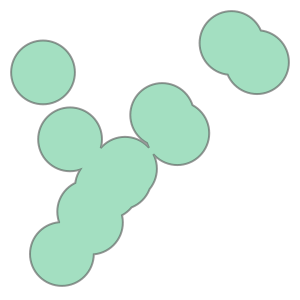

In [110]:
# Turn group of polygons into single multipolygon
my_union = two_mile_buffer.geometry.unary_union
print('Type:', type(my_union))

# Show the MultiPolygon object
my_union

We use the contains() method to check if the multipolygon contains a point. We'll use the release incident from earlier in the tutorial, which we know is roughly 3781 feet to the closest monitoring station.

In [111]:
# The closest station is less than two miles away
my_union.contains(releases.iloc[360].geometry)

True

But not all releases occured within two miles of an air monitoring station!

In [112]:
# The closest station is more than two miles away
my_union.contains(releases.iloc[358].geometry)

False

### Exercise for part V

You are part of a crisis response team, and you want to identify how hospitals have been responding to crash collisions in New York City.

<center>
<img src="https://i.imgur.com/wamd0n7.png" width="450"><br/>
</center>

#### Visualize the collision data.

The code cell below to load a GeoDataFrame `collisions` tracking major motor vehicle collisions in 2013-2018.

In [115]:
collisions = gpd.read_file("../datasets/Miscellaneous/geospatial-learn-course-data/NYPD_Motor_Vehicle_Collisions/NYPD_Motor_Vehicle_Collisions.shp")
collisions.head()

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET,CROSS STRE,OFF STREET,...,CONTRIBU_2,CONTRIBU_3,CONTRIBU_4,UNIQUE KEY,VEHICLE TY,VEHICLE _1,VEHICLE _2,VEHICLE _3,VEHICLE _4,geometry
0,07/30/2019,0:00,BRONX,10464,40.841100,-73.784960,"(40.8411, -73.78496)",None,None,121 PILOT STREET,...,Unspecified,None,None,4180045,Sedan,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,None,None,POINT (1043750.211 245785.815)
1,07/30/2019,0:10,QUEENS,11423,40.710827,-73.770660,"(40.710827, -73.77066)",JAMAICA AVENUE,188 STREET,None,...,None,None,None,4180007,Sedan,Sedan,None,None,None,POINT (1047831.185 198333.171)
2,07/30/2019,0:25,None,None,40.880318,-73.841286,"(40.880318, -73.841286)",BOSTON ROAD,None,None,...,None,None,None,4179575,Sedan,Station Wagon/Sport Utility Vehicle,None,None,None,POINT (1028139.293 260041.178)
3,07/30/2019,0:35,MANHATTAN,10036,40.756744,-73.984590,"(40.756744, -73.98459)",None,None,155 WEST 44 STREET,...,None,None,None,4179544,Box Truck,Station Wagon/Sport Utility Vehicle,None,None,None,POINT (988519.261 214979.320)
4,07/30/2019,10:00,BROOKLYN,11223,40.600090,-73.965910,"(40.60009, -73.96591)",AVENUE T,OCEAN PARKWAY,None,...,None,None,None,4180660,Station Wagon/Sport Utility Vehicle,Bike,None,None,None,POINT (993716.669 157907.212)


Use the "LATITUDE" and "LONGITUDE" columns to create an interactive map to visualize the collision data.  What type of map do you think is most effective?

In [116]:
m_1 = folium.Map(location=[40.7, -74], zoom_start=11) 

# Visualize the collision data
HeatMap(data=collisions[['LATITUDE', 'LONGITUDE']], radius=9).add_to(m_1)

# Show the map
embed_map(m_1, "../outputs/q_1.html")

#### Understand hospital coverage.

Run the next code cell to load the hospital data.

In [117]:
hospitals = gpd.read_file("../datasets/Miscellaneous/geospatial-learn-course-data/nyu_2451_34494/nyu_2451_34494.shp")
hospitals.head()

,id,name,address,zip,factype,facname,capacity,capname,bcode,xcoord,ycoord,latitude,longitude,geometry
0,317000001H1178,BRONX-LEBANON HOSPITAL CENTER - CONCOURSE DIVI...,1650 Grand Concourse,10457,3102,Hospital,415,Beds,36005,1008872.0,246596.0,40.843490,-73.911010,POINT (1008872.000 246596.000)
1,317000001H1164,BRONX-LEBANON HOSPITAL CENTER - FULTON DIVISION,1276 Fulton Ave,10456,3102,Hospital,164,Beds,36005,1011044.0,242204.0,40.831429,-73.903178,POINT (1011044.000 242204.000)
2,317000011H1175,CALVARY HOSPITAL INC,1740-70 Eastchester Rd,10461,3102,Hospital,225,Beds,36005,1027505.0,248287.0,40.848060,-73.843656,POINT (1027505.000 248287.000)
3,317000002H1165,JACOBI MEDICAL CENTER,1400 Pelham Pkwy,10461,3102,Hospital,457,Beds,36005,1027042.0,251065.0,40.855687,-73.845311,POINT (1027042.000 251065.000)
4,317000008H1172,LINCOLN MEDICAL & MENTAL HEALTH CENTER,234 E 149 St,10451,3102,Hospital,362,Beds,36005,1005154.0,236853.0,40.816758,-73.924478,POINT (1005154.000 236853.000)


In [118]:
m_2 = folium.Map(location=[40.7, -74], zoom_start=11) 

# Visualize the hospital locations
for idx, row in hospitals.iterrows():
    Marker([row['latitude'], row['longitude']], popup=row['name']).add_to(m_2)

# Show the map
embed_map(m_2, "../outputs/q_2.html")

#### When was the closest hospital more than 10 kilometers away?

Let's create a DataFrame `outside_range` containing all rows from `collisions` with crashes that occurred more than 10 kilometers from the closest hospital.

Note that both `hospitals` and `collisions` have EPSG 2263 as the coordinate reference system, and EPSG 2263 has units of meters.

In [119]:
coverage = gpd.GeoDataFrame(geometry=hospitals.geometry).buffer(10000)
my_union = coverage.geometry.unary_union
outside_range = collisions.loc[~collisions["geometry"].apply(lambda x: my_union.contains(x))]

The next code cell calculates the percentage of collisions that occurred more than 10 kilometers away from the closest hospital.

In [120]:
percentage = round(100*len(outside_range)/len(collisions), 2)
print("Percentage of collisions more than 10 km away from the closest hospital: {}%".format(percentage))

Percentage of collisions more than 10 km away from the closest hospital: 15.12%


#### Make a recommender.

When collisions occur in distant locations, it becomes even more vital that injured persons are transported to the nearest available hospital.

With this in mind, you decide to create a recommender that:
- takes the location of the crash (in EPSG 2263) as input,
- finds the closest hospital (where distance calculations are done in EPSG 2263), and 
- returns the name of the closest hospital. 

In [121]:
def best_hospital(collision_location):
    idx_min = hospitals.geometry.distance(collision_location).idxmin()
    my_hospital = hospitals.iloc[idx_min]
    name = my_hospital["name"]
    latitude = my_hospital["latitude"]
    longitude = my_hospital["longitude"]
    return pd.Series({'name': name, 'lat': latitude, 'long': longitude})

In [122]:
# Test your function: this should suggest CALVARY HOSPITAL INC
print(best_hospital(outside_range.geometry.iloc[0]))

name    CALVARY HOSPITAL INC
lat                  40.8481
long                -73.8437
dtype: object


#### Which hospital is under the highest demand?

Considering only collisions in the `outside_range` DataFrame, which hospital is most recommended?  

The answer should be a Python string that exactly matches the name of the hospital returned by the function you created.

In [123]:
highest_demand = outside_range.geometry.apply(best_hospital).name.value_counts().idxmax()

#### Where should the city construct new hospitals?

Run the next code cell (without changes) to visualize hospital locations, in addition to collisions that occurred more than 10 kilometers away from the closest hospital. 

In [124]:
m_6 = folium.Map(location=[40.7, -74], zoom_start=11) 

folium.GeoJson(coverage.geometry.to_crs(epsg=4326)).add_to(m_6)
HeatMap(data=outside_range[['LATITUDE', 'LONGITUDE']], radius=9).add_to(m_6)
folium.LatLngPopup().add_to(m_6)

embed_map(m_6, '../outputs/m_6.html')

Click anywhere on the map to see a pop-up with the corresponding location in latitude and longitude.

The city of New York reaches out to you for help with deciding locations for two brand new hospitals.  They specifically want your help with identifying locations to bring the calculated percentage from previous step to less than ten percent.  Using the map (and without worrying about zoning laws or what potential buildings would have to be removed in order to build the hospitals), can you identify two locations that would help the city accomplish this goal?  

Put the proposed latitude and longitude for hospital 1 in `lat_1` and `long_1`, respectively.  (Likewise for hospital 2.)

Then, run the rest of the cell as-is to see the effect of the new hospitals.  Our goal is that the two new hospitals bring the percentage to less than ten percent.

In [125]:
# Proposed location of hospital 1
lat_1 = 40.6714
long_1 = -73.8492

# Proposed location of hospital 2
lat_2 = 40.6702
long_2 = -73.7612

try:
    new_df = pd.DataFrame(
        {'Latitude': [lat_1, lat_2],
         'Longitude': [long_1, long_2]})
    new_gdf = gpd.GeoDataFrame(new_df, geometry=gpd.points_from_xy(new_df.Longitude, new_df.Latitude))
    new_gdf.crs = {'init' :'epsg:4326'}
    new_gdf = new_gdf.to_crs(epsg=2263)
    # get new percentage
    new_coverage = gpd.GeoDataFrame(geometry=new_gdf.geometry).buffer(10000)
    new_my_union = new_coverage.geometry.unary_union
    new_outside_range = outside_range.loc[~outside_range["geometry"].apply(lambda x: new_my_union.contains(x))]
    new_percentage = round(100*len(new_outside_range)/len(collisions), 2)
    print("(NEW) Percentage of collisions more than 10 km away from the closest hospital: {}%".format(new_percentage))
    # Did you help the city to meet its goal?
    q_6.check()
    # make the map
    m = folium.Map(location=[40.7, -74], zoom_start=11) 
    folium.GeoJson(coverage.geometry.to_crs(epsg=4326)).add_to(m)
    folium.GeoJson(new_coverage.geometry.to_crs(epsg=4326)).add_to(m)
    for idx, row in new_gdf.iterrows():
        Marker([row['Latitude'], row['Longitude']]).add_to(m)
    HeatMap(data=new_outside_range[['LATITUDE', 'LONGITUDE']], radius=9).add_to(m)
    folium.LatLngPopup().add_to(m)
    display(embed_map(m, 'q_6.html'))
except:
    pass

(NEW) Percentage of collisions more than 10 km away from the closest hospital: 9.12%


## Other resources

[OSMNX to retrieve Open Street Maps](https://towardsdatascience.com/retrieving-openstreetmap-data-in-python-1777a4be45bb?)  